In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import pickle



### Import the data

In [5]:
df_complete_ml = pd.read_csv('/content/drive/MyDrive/Machine Learning Course/complete_dataset_ml_delays.csv')

In [7]:
incident_size = 1665 # 1677 is the count for the smallest type of incident
balanced_sample = df_complete_ml.groupby(by=['Incident'], group_keys=False)\
                                    .apply(lambda x: x.sample(n=incident_size, random_state=42))\
                                    .reset_index(drop=True)

<ipython-input-7-1cd4f86c82ca>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=incident_size, random_state=42))\


### Dividinig the data

In [176]:
X = balanced_sample[['Day Hour', 'Day', 'Month', 'Incident', 'Lat', 'Lon', 'Mean Temp (°C)', 'Precipitation']]
y = balanced_sample['Min Delay']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=balanced_sample['Incident'])

### Defining the pipeline

In [177]:
pipeline_steps =[('standardscaler', StandardScaler()),
 ('svr',SVR(kernel = 'rbf', C=100, epsilon=0.2, gamma= 4))]

pipeline = Pipeline(steps=pipeline_steps)

### Grid search

In [183]:
param_grids = [

    {
        'svr__kernel': ['rbf'],
        'svr__C': [50,100],
        'svr__gamma': list(range(50, 200, 50)),
        'svr__epsilon': [0.01,0.001]
    },
    {
        'svr__kernel': ['rbf'],
        'svr__C': [80,120],
        'svr__gamma': list(range(10, 50, 10)),
        'svr__epsilon': [0.001]
    },
    {
        'svr__kernel': ['rbf'],
        'svr__C': [100],
        'svr__gamma': list(range(1, 10, 1)),
        'svr__epsilon': [0.001]
    },
    {
        'svr__kernel': ['rbf'],
        'svr__C': [80,100,120],
        'svr__gamma': [5],
        'svr__epsilon': [0.1,0.01,0.001]
    },
    {
        'svr__kernel': ['rbf'],
        'svr__C': [100],
        'svr__gamma': [5],
        'svr__epsilon': [0.1,0.3,0.5]
    },
    {
        'svr__kernel': ['poly'],
        'svr__C': [1],
        'svr__degree': [2,4],
        'svr__gamma': [1],
        'svr__epsilon': [0.01]
    }
]

In [184]:
grid_search = GridSearchCV(pipeline, param_grids[4], n_jobs=-1, cv=3, scoring='neg_mean_squared_error',verbose=3)


### Training the grid search

In [185]:
grid_search.fit(X_train_val, y_train_val)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr',
                                        SVR(C=100, epsilon=0.2, gamma=4))]),
             n_jobs=-1,
             param_grid={'svr__C': [100], 'svr__epsilon': [0.1, 0.3, 0.5],
                         'svr__gamma': [5], 'svr__kernel': ['rbf']},
             scoring='neg_mean_squared_error', verbose=3)

In [188]:
best_svr = grid_search.best_estimator_

In [187]:
gs_results = pd.DataFrame(grid_search.cv_results_)[['param_svr__C','param_svr__epsilon','param_svr__gamma','param_svr__kernel','mean_test_score','rank_test_score']]
gs_results.sort_values(by='rank_test_score').to_csv('/content/drive/MyDrive/Machine Learning Course/grid_search_results_rbf5.csv')

In [189]:
with open('/content/drive/MyDrive/Machine Learning Course/best_svr_model.pkl', 'wb') as f:
    pickle.dump(best_svr, f)
    f.close()

### Testing the model

In [190]:
with open('/content/drive/MyDrive/Machine Learning Course/best_svr_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    f.close()

In [191]:
loaded_model.fit(X_train_val, y_train_val)

y_pred_train = loaded_model.predict(X_train_val)
y_pred_test = loaded_model.predict(X_test)

mse_train = mean_squared_error(y_train_val, y_pred_train)
mse_val = mean_squared_error(y_test, y_pred_test)

print('errors:')
print('train:', mse_train)
print('val:', mse_val)

errors:
train: 0.04696358245404561
val: 2.242988013773442


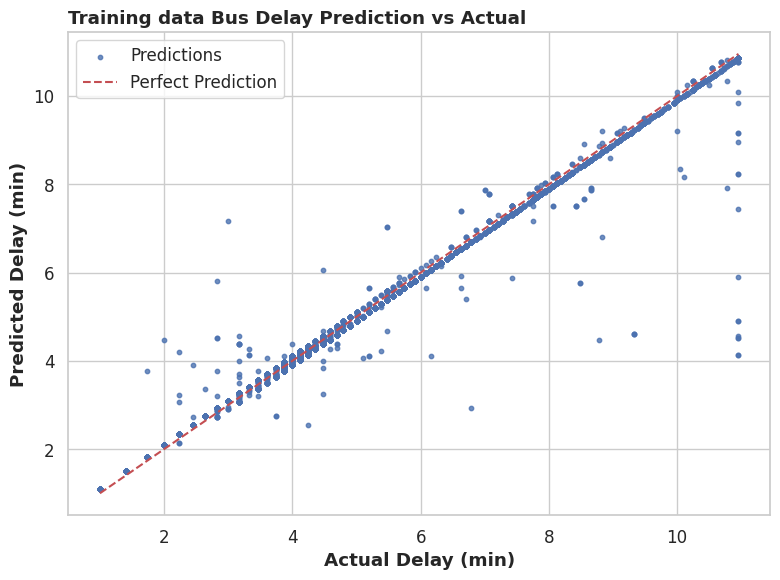

In [194]:
sns.set(style='whitegrid', font_scale=1.1)

plt.figure(figsize=(8, 6))
plt.scatter(y_train_val, y_pred_train, s=10, alpha=0.8, label='Predictions')

min_val = min(min(y_train_val), min(y_pred_train))
max_val = max(max(y_train_val), max(y_pred_train))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Delay (min)', weight='bold')
plt.ylabel('Predicted Delay (min)', weight='bold')
plt.title('Training data Bus Delay Prediction vs Actual', loc='left', weight='bold')
plt.legend()
plt.tight_layout()
plt.show()

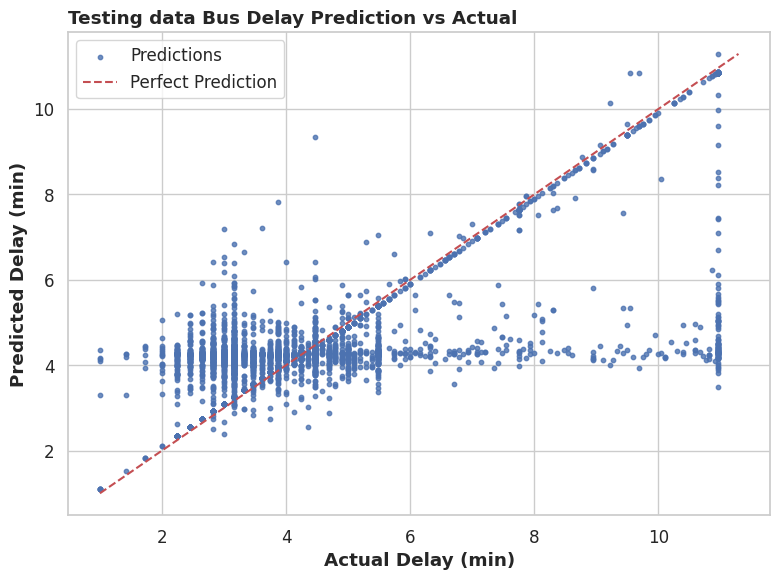

In [195]:
sns.set(style='whitegrid', font_scale=1.1)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, s=10, alpha=0.8, label='Predictions')

min_val = min(min(y_pred_test), min(y_test))
max_val = max(max(y_pred_test), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Delay (min)', weight='bold')
plt.ylabel('Predicted Delay (min)', weight='bold')
plt.title('Testing data Bus Delay Prediction vs Actual', loc='left', weight='bold')
plt.legend()
plt.tight_layout()
plt.show()